To install the required python packages, you can uncomment the lines below. Versions of matplotlib older than 3.4 may not support arrays of alphas for scatter plots, which will break generating figure 2E. Otherwise it should work fine.

In [1]:
#!pip install pandas
#!pip install "matplotlib>=3.4"
#!pip install numpy

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

This notebook, gives a small demo of analyzing the results of the compass algorithm and replicates figures 2E and 2C from the paper.

The file "extdata/Th17/reactions.tsv" is the outputs of a compass run and "extdata/Th17/cell_metadata.csv" is cell 
metadata, in this case it is only used to know the condition of the Th17 cells (pathogenic vs. non-pathogenic)

In [3]:
dir = '/Genomics/pritykinlab/zzhao/metabolic_analysis/metabolic_analysis/compass_white'
reactions = pd.read_csv(f"{dir}/reactions.tsv", sep="\t", index_col = 0)

In [4]:
cell_metadata = pd.read_csv("/Genomics/pritykinlab/zzhao/bulkRNA/datafiles/metadata_cleaned.csv", index_col = 0)
cell_metadata['tissue'] = cell_metadata['filename'].str.replace('--', '-').str.replace('GN-P', 'GNP').apply(lambda x: x.split('-')[-1])
cell_metadata = cell_metadata.set_index('filename')

In [5]:
# mutant = M; wild-type = W
# mutant = M; wild-type = W
M_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'M') & (cell_metadata['Gender'] == 'Male') & (cell_metadata['tissue'] == 'Liver') & (cell_metadata['Weeks Post Deletion'] == '6')]
W_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'W') & (cell_metadata['Gender'] == 'Male') & (cell_metadata['tissue'] == 'Liver') & (cell_metadata['Weeks Post Deletion'] == '6')]

# M_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'W') & (cell_metadata['Gender'] == 'Female') & (cell_metadata['tissue'] == 'Liver')]
# W_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'W') & (cell_metadata['Gender'] == 'Male') & (cell_metadata['tissue'] == 'Liver')]
# M_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'M') & (cell_metadata['Gender'] == 'Female') & (cell_metadata['tissue'] == 'Liver')]
# W_cells = cell_metadata.index[(cell_metadata['Mouse Genotype Code'] == 'W') & (cell_metadata['Gender'] == 'Female') & (cell_metadata['tissue'] == 'Liver')]

The reaction metadata for RECON2 is stored here. We'll be using the confidence scores and the subsystem groupings to filter out reactions and group them for analysis.

In [6]:
reaction_metadata = pd.read_csv("extdata/RECON2/reaction_metadata.csv", index_col = 0) 

Here is one example of a row for the reaction metadata:

In [7]:
M_cells

Index(['6DarkATG7KO1936-108-Liver', '6DarkATG7KO1950-113-Liver',
       '6LightATG7KO1956-133-Liver'],
      dtype='object', name='filename')

In [8]:
W_cells

Index(['6DarkATG7WT2013-90-Liver', '6DarkATG7WT2015-93-Liver',
       '6LightATG7WT1975-86-Liver', '6LightATG7WT1977-144-Liver'],
      dtype='object', name='filename')

In [9]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

In [10]:
def get_reaction_consistencies(compass_reaction_scores, min_range=1e-3):
    df = -np.log(compass_reaction_scores + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be.This also drops reactions that are close to constant and therefore not informative for the comparison.

In [11]:
reaction_consistencies = get_reaction_consistencies(reactions)

We use the unpaired Wilcoxon rank-sum test (equivlanet to the Mann–Whitney U test) to analyze which reactions are predicted to be more active in pathogenic Th17p cells compared to the non-pathogenic Th17n cells. Positive values indicate higher potential activity in Th17p. 

In [12]:
reaction_consistencies

,12DarkATG7KOfemale1911-21-GNP,12DarkATG7KOfemale1911-22-iWAT,12DarkATG7KOfemale1911-23-BAT,12DarkATG7KOfemale1911-24-Liver,12DarkATG7KOfemale1911-25-Cerebellum,12DarkATG7KOfemale1914-26-GNP,12DarkATG7KOfemale1914-27-Liver,12DarkATG7KOfemale1914-28-BAT,12DarkATG7KOfemale1914-29-Cerebellum,12DarkATG7KOfemale1914-30-iWAT,...,6LightATG7WT1977-143-BAT,6LightATG7WT1977-144-Liver,6LightATG7WT2040-125-Cerebellum,6LightATG7WT2040-126-BAT,6LightATG7WT2040-127-GNP,6LightATG7WT2040-128-Liver,6LightATG7WT2041-77-Liver,6LightATG7WT2041-78-BAT,6LightATG7WT2041-79-Cerebellum,6LightATG7WT2041-80-GNP
10FTHF5GLUtl_pos,3.379102,3.403520,3.376083,3.394776,3.391313,3.376164,3.397298,3.373264,3.393182,3.402877,...,3.380923,3.390370,3.394326,3.381237,3.372116,3.396657,3.393634,3.383547,3.394090,3.367362
10FTHF5GLUtm_pos,3.154236,3.176589,3.134862,3.244040,3.156955,3.164309,3.244649,3.128894,3.154075,3.171719,...,3.135561,3.240868,3.153868,3.137587,3.153704,3.242839,3.243242,3.139367,3.157722,3.134589
10FTHF6GLUtl_pos,3.267017,3.295814,3.252824,3.312579,3.281204,3.267654,3.315894,3.248509,3.281665,3.293768,...,3.260056,3.306713,3.282006,3.259618,3.260843,3.313779,3.311468,3.263019,3.282577,3.249670
10FTHF6GLUtm_pos,3.140140,3.167134,3.118743,3.235880,3.146178,3.150333,3.236922,3.111404,3.141795,3.161723,...,3.117880,3.232371,3.141945,3.122377,3.138921,3.234819,3.235003,3.126086,3.147346,3.119868
10FTHF7GLUtl_pos,3.224334,3.257145,3.205691,3.274856,3.241458,3.224872,3.278691,3.200579,3.241882,3.254605,...,3.213652,3.268169,3.242185,3.212550,3.217166,3.276350,3.273703,3.217016,3.243015,3.205123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_decdicoa(c)_neg,2.007450,2.040350,2.027324,2.052876,2.039537,2.004451,2.050983,2.022578,2.039834,2.032945,...,2.026281,2.038968,2.043489,2.029756,2.003157,2.048415,2.045266,2.025817,2.039693,2.000908
sink_octdececoa(c)_neg,1.778795,1.821326,1.816431,1.843250,1.799891,1.777295,1.839228,1.811043,1.800139,1.810962,...,1.816859,1.832365,1.799631,1.816990,1.774096,1.839924,1.837642,1.805043,1.798912,1.770206
sink_pre_prot(r)_neg,7.514938,7.560039,7.513552,7.522777,7.566481,7.516248,7.529374,7.510868,7.569434,7.560545,...,7.514068,7.519382,7.575424,7.514377,7.508902,7.523378,7.515323,7.509125,7.567414,7.503539
sink_tetdec2coa(c)_neg,2.007450,2.040350,2.027324,2.052876,2.039537,2.004451,2.050983,2.022578,2.039834,2.032945,...,2.026281,2.038968,2.043489,2.029756,2.003157,2.048415,2.045266,2.025817,2.039693,2.000908


In [13]:
wilcox_results = wilcoxon_test(reaction_consistencies, W_cells, M_cells)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / pooled_std
/tmp/ipykernel_219530/1804728428.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x

Next we join the metadata to the reactions in a new dataframe W, so that we can filter out non-core reactions. More specifically, we remove reactions with confidence other than 0 or 4 (4 = most confident; 0 = unassigned confidence) and filter out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [14]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([1, 2, 3, 4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

Here is one example of a row of the reuslting dataframe for a reaction:

The "_neg" or "_pos" suffixes indicate one direction of a bidirectional reaction. The "_pos" direction indicates positive flux through the reaction. For this example reaction it indicates water, oxygen, and putrescine are being consumed by this reaction to produce ammonium, hyrodgen peroxide, and 4-Aminobutanal.

In [15]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

In [17]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

In [27]:
data.sort_values(['wilcox_pval']).head(20)

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
CYSGLTH_pos,0.0,0.057143,-1.747134,1.0,CYSGLTH,Glutathione:cystine oxidoreductase,1.00 * L-cystine [c] + 2.00 * Reduced glutathi...,NaN,Methionine and cysteine metabolism,1.8.4.4,4.0
LTD4DP_pos,0.0,0.057143,-3.092362,1.0,LTD4DP,Leukotriene D4 dipeptidase,1.00 * Water [c] + 1.00 * Leukotriene D4 [c] -...,NaN,Eicosanoid metabolism,2.3.2.2,4.0
PUNP7_neg,0.0,0.057143,-2.174399,1.0,PUNP7,purine-nucleoside phosphorylase (Xanthosine),1.00 * hydrogenphosphate [c] + 1.00 * xanthosi...,PNP2,Nucleotide interconversion,3.4.2.1,4.0
ATPH2e_pos,0.0,0.057143,-2.739122,1.0,ATPH2e,ATP diphosphohydrolase,1.00 * Water [e] + 1.00 * ADP [e] --> 1.00 * p...,ENTPD1; ENTPD2; ENTPD3; ENTPD5; ENTPD6; ENTPD8,Nucleotide interconversion,3.6.1.5,4.0
LTC4CP_pos,0.0,0.057143,-3.092362,1.0,LTC4CP,Leukotriene C4 carboxypeptidase,1.00 * Water [c] + 1.00 * leukotriene C4(2-) [...,NaN,Eicosanoid metabolism,2.3.2.2,2.0
LTC4CP_neg,0.0,0.057143,-3.092362,1.0,LTC4CP,Leukotriene C4 carboxypeptidase,1.00 * Water [c] + 1.00 * leukotriene C4(2-) [...,NaN,Eicosanoid metabolism,2.3.2.2,2.0
BAAT1x_pos,12.0,0.057143,1.377544,1.0,BAAT1x,bile acid Coenzyme A: amino acid N-acyltransfe...,1.00 * Glycine [x] + 1.00 * choloyl-CoA(4-) [x...,BAAT,Bile acid synthesis,2.3.1.65,4.0
3MOX4HOXPGALDOX_pos,0.0,0.057143,-2.574423,1.0,3MOX4HOXPGALDOX,3-Methoxy-4-hydroxyphenylglycolaldehyde:NAD+ o...,1.00 * Water [c] + 1.00 * Nicotinamide adenine...,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,Tyrosine metabolism,1.2.1.5,2.0
PUNP3_pos,0.0,0.057143,-2.174399,1.0,PUNP3,purine-nucleoside phosphorylase (Guanosine),1.00 * hydrogenphosphate [c] + 1.00 * Guanosin...,PNP2,Purine catabolism,3.4.2.1,4.0
BAAT4x_pos,12.0,0.057143,1.377544,1.0,BAAT4x,bile acid Coenzyme A: amino acid N-acyltransfe...,1.00 * Glycine [x] + 1.00 * chenodeoxycholoyl ...,BAAT,Bile acid synthesis,2.3.1.65,2.0


<AxesSubplot:>

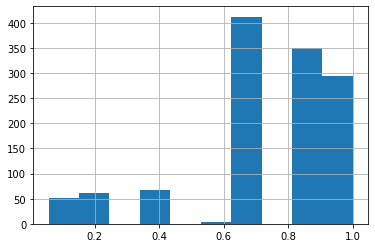

In [23]:
data['wilcox_pval'].hist()

<AxesSubplot:>

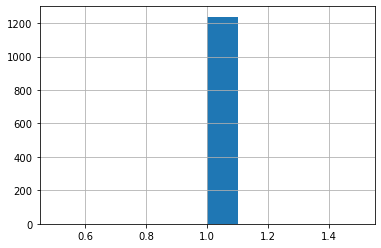

In [18]:
data['adjusted_pval'].hist()

Text(0.5, 0, "Cohen's d")

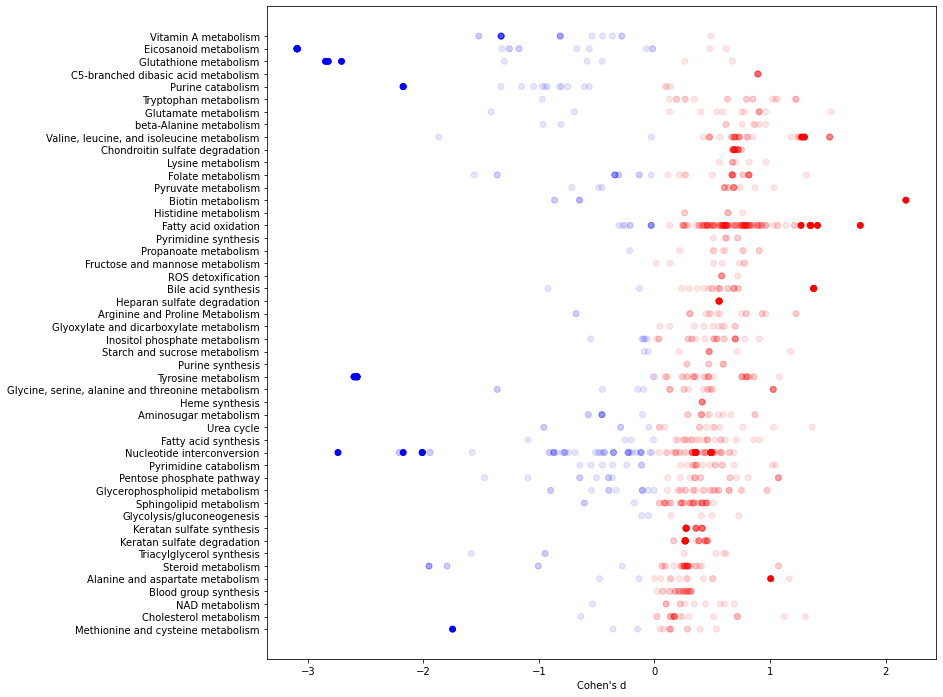

In [25]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] <=1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['wilcox_pval'].map(lambda x: 1.0 if x < 0.1 else 0.1)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")